In [1]:
import dataclasses
import os
from datetime import datetime

# utils
import h5py
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
import torch_geometric
from sklearn.model_selection import train_test_split
from torch_geometric.utils import to_dense_batch
from tqdm.notebook import tqdm, trange

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Utils

In [2]:
from utils import model_size
from utils.losses import chamfer_dist, chamfer_dist_repulsion, density_chamfer_dist

Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


### Load data

In [3]:
from torch_geometric.loader import DataLoader as PyGLoader
from utils.data import PairData, PCDDataset, load_h5_data

### Viz

In [4]:
from utils.viz import viz_many, viz_many_mpl

### Configs

In [5]:
from omegaconf import OmegaConf

In [6]:
data_path = os.path.join("..", "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")

exp_conf = OmegaConf.load(os.path.join("conf", "config.yaml"))
model_config = exp_conf.model_config
train_config = exp_conf.train_config
data_config = exp_conf.data_config

In [7]:
print(OmegaConf.to_yaml(exp_conf))

name: pugcn-baseline-alphavar
model_config:
  r: 4
  k: 20
  dilations:
  - 1
  - 2
  n_idgcn_blocks: 1
  channels: 24
  n_dgcn_blocks: 2
  use_bottleneck: true
  use_pooling: true
  use_residual: true
  conv: edge
  pool_type: mean
  dynamic: false
  use_refiner: true
  upsampler: nodeshuffle
  hierarchical: false
train_config:
  batch_size: 8
  epochs: 10
  optimizer: adam
  lr: 0.001
  betas:
  - 0.9
  - 0.999
  save_every: 5
  augment: true
  loss_fn: cd
  k_loss: 4
data_config:
  path: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
  num_point: 256
  skip_rate: 1
  use_randominput: true
  rng_seed: 42



# Data

In [8]:
# Load dataset
dataset = PCDDataset.from_h5(
    data_path,
    num_point=data_config.num_point,
    up_ratio=model_config.r,
    skip_rate=data_config.skip_rate,
    seed=data_config.rng_seed,
)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 69000 samples


In [9]:
# Check one sample
data = dataset[42]
data_cloud, gt_cloud = data.pos_s, data.pos_t

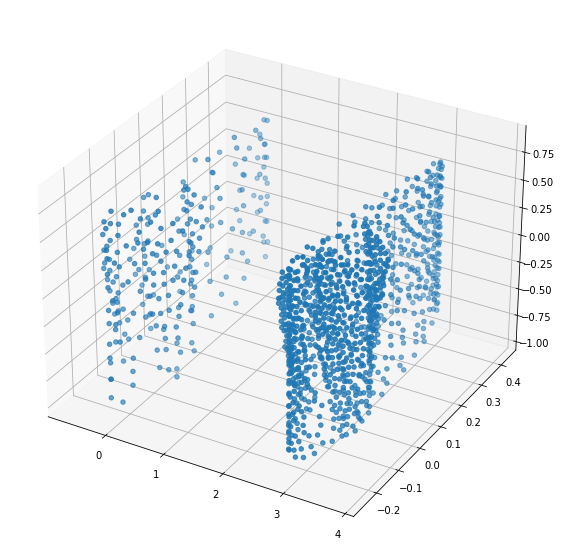

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
viz_many_mpl([data_cloud, gt_cloud], ax=ax)

# Training

In [11]:
from pugcn_lib import PUGCN, PUInceptionTransformer
from pugcn_lib.models import JustUpsample

In [12]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [13]:
# Split into train and validation if you wish
# train_perc = .8
# trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)], generator=torch.Generator().manual_seed(42))

In [14]:
# Set augmentation for the datasets
dataset.augment = train_config.augment
# trainset.dataset.augment = True
# valset.dataset.augment = False

In [15]:
trainloader = PyGLoader(dataset, batch_size=train_config.batch_size, follow_batch=["pos_s", "pos_t"])
# trainloader = PyGLoader(trainset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
# valloader = PyGLoader(valset, batch_size=train_config.batch_size, shuffle=False, follow_batch = ['pos_s', 'pos_t'])

In [16]:
model = PUGCN(**model_config).to(device)
# model = PUInceptionTransformer(**model_config).to(device)
# model = JustUpsample(**model_config).to(device)
# loss_fn = loss_fn = ChamferLoss()
loss_fn = train_config.loss_fn
optimizer = torch.optim.Adam(params=model.parameters(), lr=train_config.lr, betas=train_config.betas)

In [17]:
model

PUGCN(
  (feature_extractor): InceptionFeatureExtractor(
    (knn): DilatedKnnGraph(
      (_dilated): Dilated()
    )
    (knn1): Dilated()
    (pre_gcn): DynConv(
      (gconv): EdgeConv(nn=MLP(
        (0): Linear(in_features=6, out_features=24, bias=True)
      ))
      (dilated_knn_graph): DilatedKnnGraph(
        (_dilated): Dilated()
      )
    )
    (layers): ModuleList(
      (0): InceptionDenseGCN(
        (bottleneck): MLP(24, 8)
        (dense_gcns): ModuleList(
          (0): DenseGCN(
            (blocks): ModuleList(
              (0): DenseGraphBlock(
                (body): GraphConv(
                  (gconv): EdgeConv(nn=MLP(
                    (0): Linear(in_features=16, out_features=8, bias=True)
                  ))
                )
              )
              (1): DenseGraphBlock(
                (body): GraphConv(
                  (gconv): EdgeConv(nn=MLP(
                    (0): Linear(in_features=32, out_features=8, bias=True)
                  ))
     

In [18]:
model_size(model, unit="KB")

39.336

/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/einops/einops.py:202: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  inferred_length: int = length // known_product


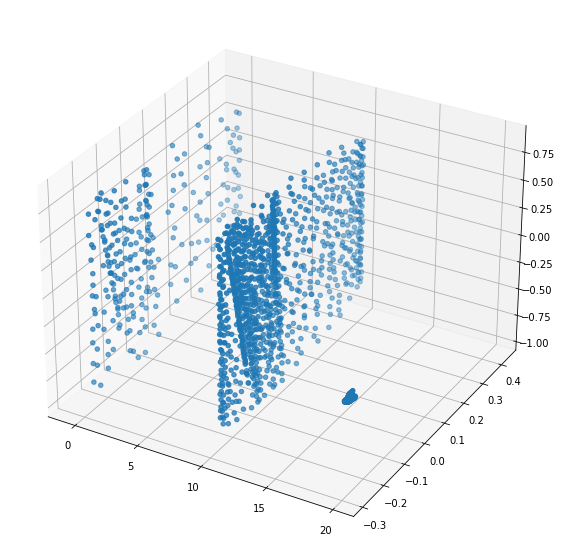

In [19]:
pred = model(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

viz_many_mpl([data_cloud, gt_cloud, pred], d=10, ax=ax)

In [20]:
density_chamfer_dist(torch.tensor(pred).unsqueeze(0).to(device), gt_cloud.unsqueeze(0).to(device))

(tensor([0.9800], device='cuda:0'),
 tensor([0.3254], device='cuda:0'),
 tensor([0.4289], device='cuda:0'))

In [21]:
def train(model, trainloader, loss_fn, optimizer, gamma=0, before_refiner_loss=False):

    total_loss = 0.0
    total_proportion = 0.0
    for (i, d) in (t := tqdm(enumerate(trainloader), total=len(trainloader))):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        # Train step
        optimizer.zero_grad()
        pred = model(p, batch=p_batch)

        # Transform to dense batches
        pred, _ = to_dense_batch(pred, q_batch)  # [B, N * r, 3]
        gt, _ = to_dense_batch(q, q_batch)  # # [B, N * r, 3]

        # Calculate loss

        if loss_fn == "dcd":
            dcd, _, _ = density_chamfer_dist(pred, gt)

            loss = dcd.mean()
        elif loss_fn == "cd":
            _, _, cd_t = density_chamfer_dist(pred, gt)
            loss = cd_t.mean()
        elif loss_fn == "cd_rep":
            loss, prop = chamfer_dist_repulsion(pred, gt, k=train_config.k_loss, return_proportion=True)
            total_proportion += prop
        else:
            raise ValueError('Loss must be "cd" or "dcd"')

        if before_refiner_loss:
            with torch.no_grad():
                pred2 = model.predict_unrefined(p, p_batch)
            pred2, _ = to_dense_batch(pred2, q_batch)
            if loss_fn == "dcd":
                dcd, _, _ = density_chamfer_dist(pred2, gt)
                loss2 = dcd.mean()
            elif loss_fn == "cd":
                _, _, cd_t = density_chamfer_dist(pred2, gt)
                loss2 = cd_t.mean()
            elif loss_fn == "cd_rep":
                loss2 = chamfer_dist_repulsion(pred2, gt, k=4)
            else:
                raise ValueError('Loss must be "cd" or "dcd"')
            loss = (1 - gamma) * loss + gamma * loss2

        if model_config.upsampler == "variational":
            mean = model.upsampler.upsampler.last_z_mean
            log_var = model.upsampler.upsampler.last_z_log_var
            kl_loss = (-0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var), dim=1)).mean()
            loss = (loss + kl_loss) / 2

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        t.set_description(
            f"loss = {total_loss / ((i+1) * trainloader.batch_size) :.8f}\tprop={total_proportion / ((i+1) * trainloader.batch_size ) :.4f}"
        )
        # t.set_description(f"loss = {total_loss / ((i+1) * trainloader.batch_size) :.8f}")
    return total_loss / len(trainloader.dataset)

In [22]:
if "trained-models" not in os.listdir("."):
    os.mkdir("trained-models")
dir_name = f'{datetime.now().strftime("%Y-%m-%d-%H-%M")}-{exp_conf.name}'

os.mkdir(os.path.join("trained-models", dir_name))
print(f"Saving checkpoints at {dir_name}")

Saving checkpoints at 2022-06-07-21-40-pugcn-baseline-alphavar


In [23]:
OmegaConf.save(config=exp_conf, f=os.path.join("trained-models", dir_name, "config.yaml"))

In [24]:
history = OmegaConf.create()
history.train_loss = []
history.val_loss = []
for epoch in tqdm(range(1, train_config.epochs + 1)):

    train_loss = train(
        model, trainloader, loss_fn, optimizer, gamma=(1 - epoch / train_config.epochs), before_refiner_loss=True
    )
    # train_loss = train_w_refiner(model, trainloader, loss_fn, optimizer, alpha=0.5)
    history.train_loss.append(train_loss)
    # val_loss = evaluate(model, valloader, loss_fn)
    # history.val_loss.append(val_loss)

    print(f"{epoch=} \t {train_loss=:.6f}")

    if epoch == 1 or epoch % train_config.save_every == 0:
        torch.save(
            {
                "experiment_config": dict(exp_conf),
                "history": history,
                "epoch": epoch,
                "model_size": model_size(model, unit="KB"),
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            os.path.join("trained-models", dir_name, f"ckpt_epoch_{epoch}"),
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=1 	 train_loss=0.009826


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=2 	 train_loss=0.007174


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=3 	 train_loss=0.005199


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=4 	 train_loss=0.003816


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=5 	 train_loss=0.002948


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=6 	 train_loss=0.002289


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=7 	 train_loss=0.001723


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=8 	 train_loss=0.001221


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=9 	 train_loss=0.000754


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=10 	 train_loss=0.000312


In [25]:
idx = np.random.choice(len(dataset))
# dv = valset[idx]
dv = dataset[idx]
sample, gt = dv.pos_s, dv.pos_t

In [26]:
pred = model(sample.to(device)).cpu().detach().numpy()
pred

array([[-1.8142344e-01, -9.7747870e-02, -1.5099166e-01],
       [-2.1552122e-01, -1.9960105e-04, -1.1132210e-02],
       [-2.0560461e-01, -6.5504044e-02, -2.8605619e-02],
       ...,
       [ 6.1017245e-01, -5.7583320e-01, -3.0581051e-01],
       [ 6.1024779e-01, -5.7454431e-01, -3.3553609e-01],
       [ 5.9634715e-01, -5.6982577e-01, -2.6151428e-01]], dtype=float32)

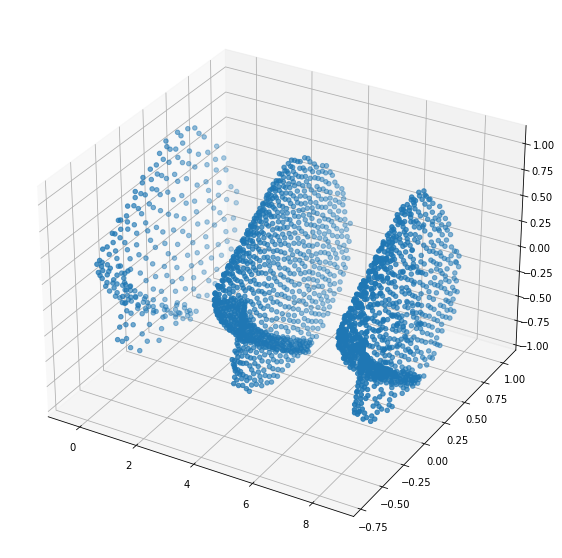

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
viz_many_mpl([sample, gt, pred], d=4, ax=ax)